# Objective
The objective here is to analyse the quarterly earnings conference call transcripts, with the help of NLP,  to identify the new themes, opportunities and risks that company management is sharing with the investors. Some exploratory data analysis to understand the topics being discussed during the earnings calls and sentiment trends.

## What are earnings call?
Every quarter, publicly listed companies are required to publish their quarterly results and file reports with the regulatory body security and exchange commission (SEC). Besides publishing these reports, on the day of the earnings release the companies, the leadership team of the company (CEO, CFO, etc.) give an overview of the results to the institutional and individual investors. The company management also have Q&A with the buy- and sell-side research analysts. These calls are also recorded and uploaded in audio on companies investor filing section.

## Where can one get earning call in a machine readable format?
There are multiple ways to get this information. One can use actual recordings (or live call) and translate it into text using machine learning tool / apis.

The earnings call is also transcripted into text and available on various websites. 

## High level summary of steps being done
- Use `Requests` library to download the webpage
- Use `Beautiful Soup` library to cleanup the html
- `Spacy` to cleanup the data like removing stop words, lematizing words
- `Gensim` to identify bi-grams
- `Scikitlearn TF-IDF` to determine the extract new topics discsussed in each call
- `WordCloud` to diplay the top themes identified using TF-IDF
- Higlighting sentiment trends using `Loughran McDonald Sentiment Word Lists`
- Fetch stock prices using `pandas_datareader`
- `Matplotlib` to create sentiment time series and stock price time series plot


### Loughran McDonald Sentiment Word Lists
We'll be using the [Loughran McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists) to identify words with sentiment. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining

## Inspiration
I came across  "Loughran McDonald Sentiment Word Lists" during my Udacity course `AI for Trading`. I highly recommend this course for the large practical knowldge the course provided. In the course sentiment analysis was performed on 10-K statements and then further used to create factors into a trading model.

### ---Let's start---

**Import all the required libraries**  
All libraries needed in this notebook are downloaded right at the start

In [1]:
import sys
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import re
from pathlib import Path
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import timedelta

%matplotlib inline

**Download the spacy small sized model**  
There are 3 models available in spacy. Small/Medium/Large. 
For this notebook small will suffice as I am not using features like word embeddings. 

In [2]:
!{sys.executable} -m spacy download en_core_web_sm
spacy_model = 'en_core_web_sm'

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


**Create spacy model object**  
The inmemory spacy model for all the subequent tasks

In [3]:
nlp = spacy.load(spacy_model)

**Create pandas dataframe containing all information used in processing**  
We begin with a simple dataframe containing information like ticker (here tickers for Google, Amazon, Facebook and Microsoft) and the link from where earnings call transcripts can be downloaded.
As we progress we will add more columns to these dataframes like relevant words in the transcripts, n_grams etc.  
Also there is a subdirectory called downloads where all the call transcripts and subsequently processed files are stored.

##### Due to non-clarification of copyrights, I removed the link of website #####

In [4]:
columns = ['ticker','quarter', 'year', 'url']
data = [
    ['GOOG','q2', 2020, '<earnings_call_transcripts.com/alphabet-inc-goog-googl-q2-2020-earnings-call-tran.html'],
    ['GOOG','q1', 2020, '<earnings_call_transcripts.com/2020/04/29/alphabet-inc-goog-googl-q1-2020-earnings-call-tran.html'],
    ['GOOG','q4', 2019, '<earnings_call_transcripts.com/2020/02/03/alphabet-inc-goog-googl-q4-2019-earnings-call-tran.html'],
    ['GOOG','q3', 2019, '<earnings_call_transcripts.com/2019/10/29/google-inc-googl-q3-2019-earnings-call-transcript.html'],

    ['AMZN','q2', 2020, '<earnings_call_transcripts.com/2020/07/31/amazon-amzn-q2-2020-earnings-call-transcript.html'],
    ['AMZN','q1', 2020, '<earnings_call_transcripts.com/2020/04/30/amazoncom-inc-amzn-q1-2020-earnings-call-transcrip.html'],
    ['AMZN','q4', 2019, '<earnings_call_transcripts.com/2020/01/31/amazoncom-inc-amzn-q4-2019-earnings-call-transcrip.html'],
    ['AMZN','q3', 2019, '<earnings_call_transcripts.com/2019/10/24/amazoncom-inc-amzn-q3-2019-earnings-call-transcrip.html'],

    ['FB','q2', 2020, '<earnings_call_transcripts.com/2020/07/31/facebook-fb-q2-2020-earnings-call-transcript.html'],
    ['FB','q1', 2020, '<earnings_call_transcripts.com/2020/04/29/facebook-inc-fb-q1-2020-earnings-call-transcript.html'],
    ['FB','q4', 2019, '<earnings_call_transcripts.com/2020/01/29/facebook-inc-fb-q4-2019-earnings-call-transcript.html'],
    ['FB','q3', 2019, '<earnings_call_transcripts.com/2019/10/31/facebook-inc-fb-q3-2019-earnings-call-transcript.html'],

    ['MSFT','q2', 2020, '<earnings_call_transcripts.com/2020/07/23/microsoft-msft-q4-2020-earnings-call-transcript.html'],
    ['MSFT','q1', 2020, '<earnings_call_transcripts.com/2020/04/30/microsoft-corp-msft-q3-2020-earnings-call-transcri.html'],
    ['MSFT','q4', 2019, '<earnings_call_transcripts.com/2019/07/18/microsoft-corp-msft-q4-2019-earnings-call-transcri.html'],
    ['MSFT','q3', 2019, '<earnings_call_transcripts.com/2019/04/25/microsoft-corp-msft-q3-2019-earnings-call-transcri.html'],
]

df = pd.DataFrame(data=data, columns=columns)
download_dir = Path("./downloads")

**Extract the date of the earnings call transcripts**  
and add this `call_date` as a new column in the dataframe

In [5]:
df['call_date'] = df['url'].apply(lambda x : pd.to_datetime(re.match(r".*(\d{4}/\d{2}/\d{2})", x).group(1)))

In [6]:
def download_transripts(df_row):
    """Download the earnings call transcript, if it does not already exist.
    The function first searches for the transcript in downloads directory.
    If it exists then read if from the this location else download and save it in download directory
    
    Parameters
    ----------
    df_row : dataframe row
       The row of the dataframe with information of the url to download and store the html
    """
    local_path = download_dir / Path(df_row['ticker'] + '-' + df_row['quarter'] + '-' + str(df_row['year']) + '.html')
    if local_path.is_file():
        print(f"File Exists {local_path}")
    else:
        print(f"Downloading {df_row['ticker']}, url: {df_row['url']}")
        url_get =  requests.get(df_row['url'])
        soup = BeautifulSoup(url_get.text)
        with open(local_path,'w') as fh:
                fh.write(str(soup)) 
    return local_path

**Call the download_transcript function and store the path of the transript file**

In [7]:
df['local_path'] = df.apply(download_transripts, axis=1)

File Exists downloads/GOOG-q2-2020.html
File Exists downloads/GOOG-q1-2020.html
File Exists downloads/GOOG-q4-2019.html
File Exists downloads/GOOG-q3-2019.html
File Exists downloads/AMZN-q2-2020.html
File Exists downloads/AMZN-q1-2020.html
File Exists downloads/AMZN-q4-2019.html
File Exists downloads/AMZN-q3-2019.html
File Exists downloads/FB-q2-2020.html
File Exists downloads/FB-q1-2020.html
File Exists downloads/FB-q4-2019.html
File Exists downloads/FB-q3-2019.html
File Exists downloads/MSFT-q2-2020.html
File Exists downloads/MSFT-q1-2020.html
File Exists downloads/MSFT-q4-2019.html
File Exists downloads/MSFT-q3-2019.html


In [8]:
def get_transcript_text(df_row):
    """Reads the downloaded call transript html, remove all the html tags from the relevant section 
    and return the plain text.
    The function also saves this text into downloads directory. If it finds the parsed plain text, 
    it returns text from the file.
    
    Parameters
    ----------
    df_row : dataframe row
       The row of the dataframe with information of the local html
    """

    local_path = download_dir / Path(df_row['ticker'] + '-' + df_row['quarter'] + '-' + str(df_row['year']) + '.txt')
    if local_path.is_file():
        print(f"File Exists {local_path}")
        #with open(local_path, "r") as fh:
        #    plain_text = fh.read()
        #return plain_text
        return local_path
    else:
        print(f"Processing {df_row['local_path']}")
        with open(df_row['local_path'], "r") as fh:
            html = fh.read()
        regex = re.compile(r'Prepared Remarks:\s*(\n*.*)\s*Call participants:',re.DOTALL)
        matches = regex.finditer(html)
        plain_text=''
        for match in matches:
            # print(match)
            plain_text = BeautifulSoup(match.group(1), 'html.parser').get_text(separator='') # remove all the html
            plain_text = re.sub("\n|\r", ".", plain_text, flags=re.MULTILINE) # remove new line
            plain_text = re.sub("\s\s+|\t", " ", plain_text) # replace multiple spaces with single space

        with open(local_path,'w') as fh:
                fh.write(plain_text) 
        return local_path #plain_text

**Get the text of the transcipt for all the companies**

In [9]:
df['plain_text'] = df.apply(get_transcript_text, axis=1)

File Exists downloads/GOOG-q2-2020.txt
File Exists downloads/GOOG-q1-2020.txt
File Exists downloads/GOOG-q4-2019.txt
File Exists downloads/GOOG-q3-2019.txt
File Exists downloads/AMZN-q2-2020.txt
File Exists downloads/AMZN-q1-2020.txt
File Exists downloads/AMZN-q4-2019.txt
File Exists downloads/AMZN-q3-2019.txt
File Exists downloads/FB-q2-2020.txt
File Exists downloads/FB-q1-2020.txt
File Exists downloads/FB-q4-2019.txt
File Exists downloads/FB-q3-2019.txt
File Exists downloads/MSFT-q2-2020.txt
File Exists downloads/MSFT-q1-2020.txt
File Exists downloads/MSFT-q4-2019.txt
File Exists downloads/MSFT-q3-2019.txt


**Add additional stop words for spacy to remove in processing the data**  
_How these words were identified as stop words?_  
Well, by going through a couple of transcripts manually as well as iteraction through the data 
i.e. unfortunately this list is created custom for the underlying data

In [10]:
additional_stop_words = ['hi', 'earning', 'conference', 'speaker', 'analyst', 'operator', 'welcome', \
                         'think', 'cost', 'result', 'primarily', 'overall', 'line', 'general', \
                          'thank', 'see', 'alphabet', 'google', 'facebook', 'amazon', 'microsoft',\
                        'business', 'customer', 'revenue', 'question', 'lady', 'gentleman', \
                        'continue', 'continuing', 'continued', 'focus', 'participant', 'see', 'seeing', \
                        'user', 'work', 'lot', 'day',  'like', 'looking', 'look', 'come', 'yes', 'include', \
                        'investor', 'director', 'expense', 'manager', 'founder', 'chairman', \
                         'chief', 'operating', 'officer', 'executive', 'financial', 'senior', 'vice', 'president', \
                        'opportunity', 'go', 'expect', 'increase', 'quarter', 'stand', 'instructions', \
                        'obviously', 'thing', 'important', 'help', 'bring', 'mention', 'yeah', 'get', 'proceed', \
                        'currency', 'example', 'believe'] 

for stopword in additional_stop_words:
    nlp.vocab[stopword].is_stop = True

**Using spacy to get list of words**  
We remove names of people, stop words (including additional stop words from above), non-alphanumeric words and prepositions (in spacy indentified as pos_ == "ADP")

In [11]:
def get_cleaned_word_list(df_row):
    """
    Returns the list of words after removing non-alphanumeric words, stop words, prepositions and names of person
    
    Parameters
    ----------
    df_row : dataframe row
       The row of the dataframe with information of the local html
    """
    print(f"Processing {df_row['ticker']}, quarter: {df_row['quarter']}, year: {df_row['year']}")
    words = []
    local_path = df_row['plain_text']
    with open(local_path, "r") as fh:
        conf_text = fh.read()
    doc = nlp(conf_text)
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            # print(ent.text, ent.label_)
            retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": ent.text})
    #print('-------------------')
    for word in doc:
        # print(word, word.lemma_, word.ent_type_)
        if word.is_alpha and word.is_ascii and not word.is_stop and \
            word.ent_type_ not in ['PERSON','DATE', 'TIME', 'ORDINAL', 'CARDINAL'] and \
            word.text.lower() not in additional_stop_words and \
            word.lemma_.lower() not in additional_stop_words:
                #print(word)
                words.append(word.lemma_.lower())
    return words

**Store in dataframe cleaned list of words from each call transcript**

In [12]:
df['words'] = df.apply(get_cleaned_word_list, axis=1)

Processing GOOG, quarter: q2, year: 2020
Processing GOOG, quarter: q1, year: 2020
Processing GOOG, quarter: q4, year: 2019
Processing GOOG, quarter: q3, year: 2019
Processing AMZN, quarter: q2, year: 2020
Processing AMZN, quarter: q1, year: 2020
Processing AMZN, quarter: q4, year: 2019
Processing AMZN, quarter: q3, year: 2019
Processing FB, quarter: q2, year: 2020
Processing FB, quarter: q1, year: 2020
Processing FB, quarter: q4, year: 2019
Processing FB, quarter: q3, year: 2019
Processing MSFT, quarter: q2, year: 2020
Processing MSFT, quarter: q1, year: 2020
Processing MSFT, quarter: q4, year: 2019
Processing MSFT, quarter: q3, year: 2019


In [13]:
df.loc[(df['ticker']=='GOOG')  & (df['call_date']=='2019-10-29'), 'words'].to_csv('downloads/2019-10-29.goog.csv')

**Using gensim identify bigrams in the cleaned wordlist**

In [14]:
tickers = df['ticker'].unique().tolist()
for ticker in tickers:
    bigram = gensim.models.Phrases(df.loc[df['ticker']==ticker,'words'], min_count=3)
    df.loc[df['ticker']==ticker,'words_ngrams'] = df.loc[df['ticker']==ticker,'words'].apply(lambda x : bigram[x]) #bi-gram e.g. 'vice president'
    # df.loc[df['ticker']==ticker,'words_ngrams'] = df.loc[df['ticker']==ticker,'words_ngrams'].apply(lambda x : bigram[x]) #bi-gram e.g. 'vice president'

**Second set of stop words are bigrams that we wish to exclude**  
Then we will get lemmatized words for all other words

In [15]:
# new bigram based stop words which can go
additional_stop_words=['gross_margin', 'come_line', 'constant_currency', 'operatorthank_proceed', 'long_term', \
                      'grow_constant', 'year_year' , 'growth', 'strong', 'great', 'maybe']
def get_lemmatized_words(df_row):
    """
    Get the lemmatized words after removing the new bigram based stopd words
    Parameters
    ----------
    df_row : dataframe row
       The row of the dataframe with information of the local html
    """
    
    print(f"Processing {df_row['ticker']}, quarter: {df_row['quarter']}, year: {df_row['year']}")
    words = []
    doc = df_row['words_ngrams']
    for word in doc:
        if word not in additional_stop_words:
            words.append(word)
    return words

**Get lemmatized words after removing stop words**

In [16]:
df['words_ngrams'] = df.apply(get_lemmatized_words, axis=1)

Processing GOOG, quarter: q2, year: 2020
Processing GOOG, quarter: q1, year: 2020
Processing GOOG, quarter: q4, year: 2019
Processing GOOG, quarter: q3, year: 2019
Processing AMZN, quarter: q2, year: 2020
Processing AMZN, quarter: q1, year: 2020
Processing AMZN, quarter: q4, year: 2019
Processing AMZN, quarter: q3, year: 2019
Processing FB, quarter: q2, year: 2020
Processing FB, quarter: q1, year: 2020
Processing FB, quarter: q4, year: 2019
Processing FB, quarter: q3, year: 2019
Processing MSFT, quarter: q2, year: 2020
Processing MSFT, quarter: q1, year: 2020
Processing MSFT, quarter: q4, year: 2019
Processing MSFT, quarter: q3, year: 2019


**Initialize the sklearn's TF-IDF Vectorizer**  
We are ignoring words with less 2.5% frequency

In [17]:
# create the transform
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,use_idf=True, min_df=0.025) #, max_df=0.90)

**Generate WordCloud based on TF-IDF frequency**  
We `fit_transform` TF-IDF vectorizer on all the earning transcripts of a given company. 
_Note: Corpus is transcripts of the given company and not the entire transcripts set._  

Higer `Term Frequency - Inverse Document Frequency (TD-IDF)` would give higher weights to words unique in the document rather than words which occur in all the documents. **Objective is to identify the words/topics company is highlighting in a a given earnings call.**  

After sorting these words, we are drawing word cloud for the top 100 words.

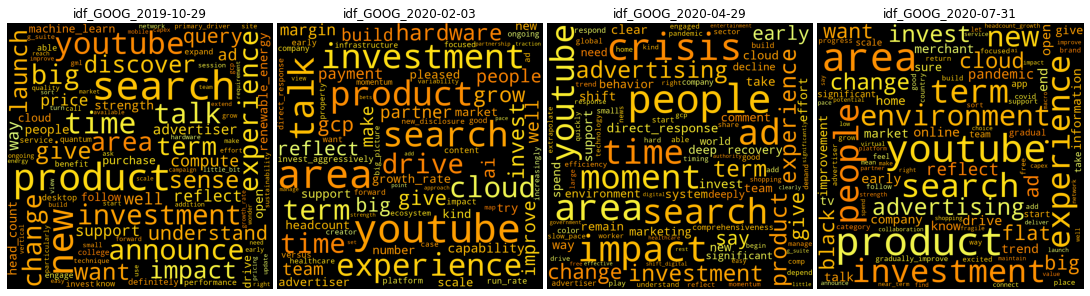

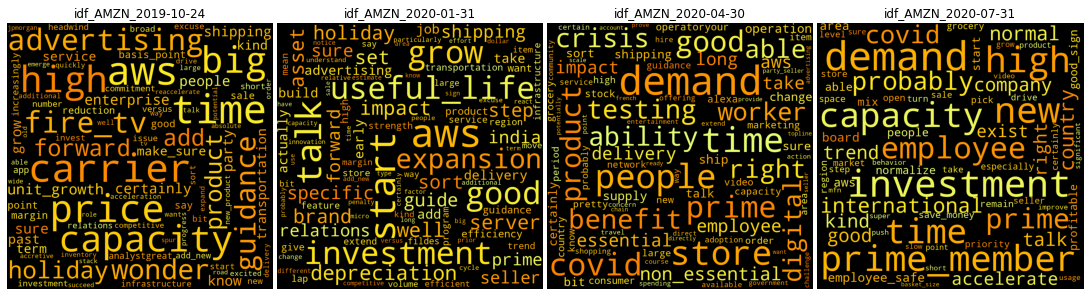

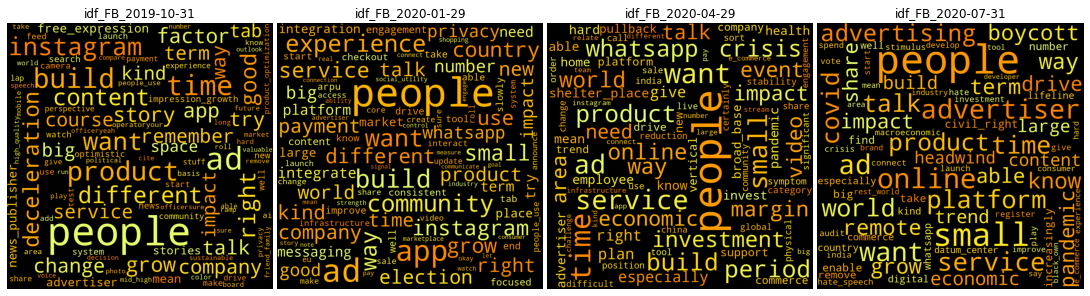

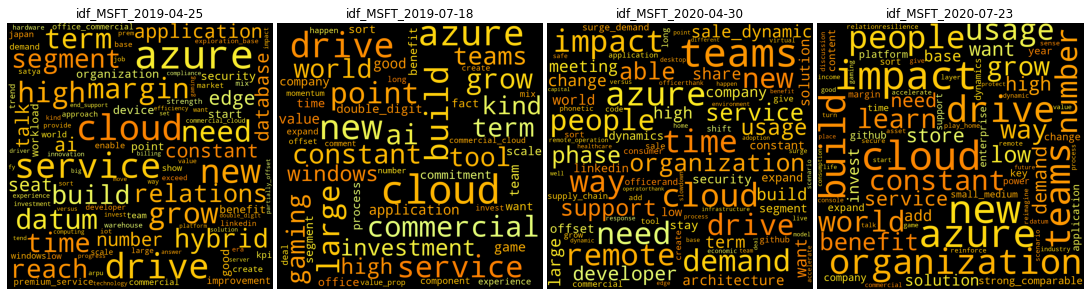

In [18]:
tickers = df['ticker'].unique().tolist()
num_top_words=100
wc = WordCloud(width = 1000, height = 1000, 
               background_color ='black', 
               min_font_size = 20,
               max_font_size=150,
               colormap='Wistia')
docs_joined = []
num_tickers = len(tickers)
for ticker in tickers:
    
    sub_df = df.loc[df['ticker']==ticker]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    docs = sub_df['words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = sub_df['call_date'].tolist()
    num_dates = len(dates)
    # tokenize and build vocab
    idf_vector = tfidf_vectorizer.fit_transform(docs)
    index=0
    fig = plt.figure(figsize=(15,15))
    for dt, doc in zip(dates, docs):
        docs_joined.extend(doc)
        
        df_idf = pd.DataFrame(idf_vector[index].T.toarray(), index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
        dict_idf_topwrds = df_idf.sort_values(by=['idf_weights'],ascending=False)[:num_top_words].to_dict()['idf_weights']

        plt.subplot(1*num_tickers, num_dates,index+1).set_title("idf_" + ticker + "_" + str(dt.date()))
        wc.generate_from_frequencies(dict_idf_topwrds)
        # plot the WordCloud image                        
        plt.imshow(wc)
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        index += 1
    # fig.savefig('WordCloud_' + ticker + '.png')

plt.show()

**Load the "Loughran Mcdonald Dictionary"**  
This dicationary has word sentiment classification into: negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'

In [19]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('loughran_mcdonald_master_dic_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
print(f'before any sentiment_df.shape {sentiment_df.shape}')
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]
print(f'after any sentiment_df.shape {sentiment_df.shape}')

before any sentiment_df.shape (85221, 7)
after any sentiment_df.shape (3926, 7)


**Convert words into Lemmatized form**  
We have stored the earning call transcript words in lemmatized form

In [20]:
word_list = nlp(" ".join(sentiment_df['word'].str.lower()))
word_lemmas = []
for word in word_list:
    # print(word.text, word.lemma_)
    word_lemmas.append(word.lemma_)

Add to the sentiment dictionary the lemmatized words

In [21]:
sentiment_df.insert(loc=7, column='lemma', value=word_lemmas)

Printing word sentiment classification for information purpose

In [22]:
# Apply the same preprocessing to these words as the 10-k words
sentiment_df = sentiment_df.drop_duplicates('lemma')
print(f'after drop_duplicates sentiment_df.shape {sentiment_df.shape}')
print()
print(f'sentiment_df[sentiments].sum()-->\n{sentiment_df[sentiments].sum()}')
print('shape is sentiment * words i.e. rows will have sentiment classification and columns are list of words with those sentiments')

after drop_duplicates sentiment_df.shape (2468, 8)

sentiment_df[sentiments].sum()-->
negative        1403
positive         230
uncertainty      199
litigious        618
constraining      93
interesting       60
dtype: int64
shape is sentiment * words i.e. rows will have sentiment classification and columns are list of words with those sentiments


Add columns to store the count of each of the sentiment

In [23]:
df = df.reindex(columns= df.columns.to_list() + sentiments)

**Create word frequency dictionary for each of sentiment word that occur in transcript**  
For e.g. (happy, great, amazing) are all positive words. If in a transcript there are 6 instances of happy(2) + great(1) + amazing(3) then we will store count 6 for positive sentiment for that transcript.

In [24]:
sentiment_vectorizer = CountVectorizer()

In [25]:
def get_sentiment_info(df_row, sentiment_vectorizer):
    """
    Get count of the words of a particular sentiment in the transcript
    Parameters
    ----------
    df_row : dataframe row
       The row of the dataframe with words_ngrams
    sentiment_vectorizer: sentiment_vectorizer instance
        To count the instance of the word sentiment
    """
    
    vector = sentiment_vectorizer.transform([" ".join(df_row['words'])])
    return np.sum(vector.toarray())


In [26]:
for sentiment in sentiments:
    sentiment_words = sentiment_df.loc[sentiment_df[sentiment],'lemma']
    sentiment_vectorizer.fit(sentiment_words)
    df[sentiment] = df.apply(get_sentiment_info, args=(sentiment_vectorizer, ), axis=1)

Let's plot the sentiment over time

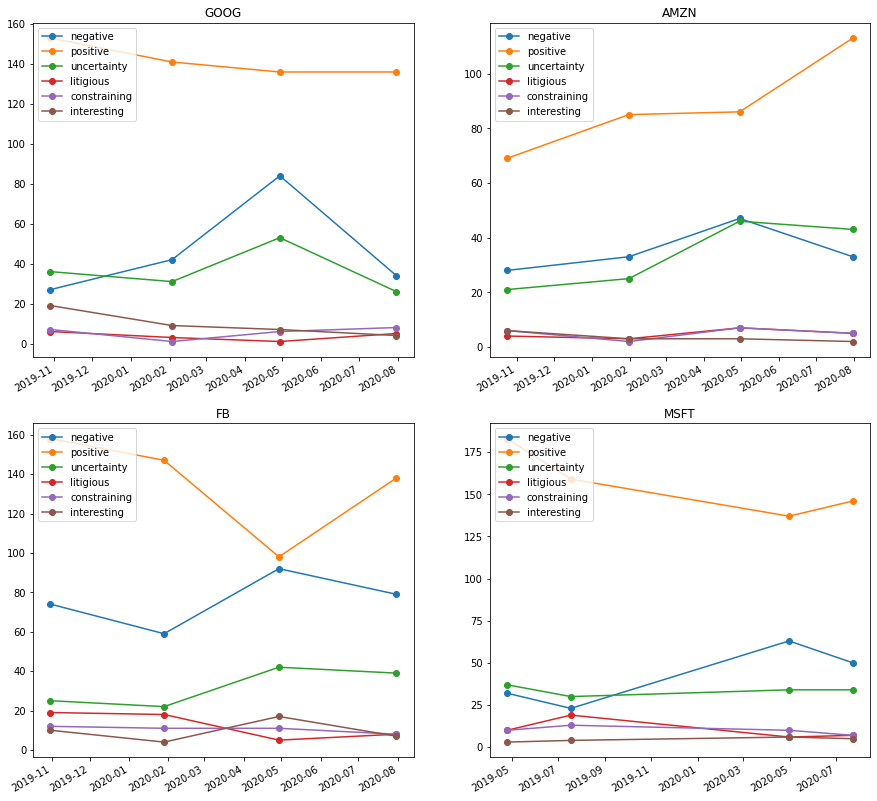

In [27]:
fig = plt.figure(figsize=(15, 15))
fig.autofmt_xdate()
tickers = df['ticker'].unique().tolist()
for index, ticker in enumerate(tickers):
    pos = 220 + index + 1 # to create fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)
    ax1 = fig.add_subplot(pos)
    sub_df = df.loc[df['ticker']==ticker,['call_date']+sentiments]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    #sub_df['call_date'] = sub_df['call_date'].astype(str)
    ax1.plot(sub_df['call_date'], sub_df[sentiments], marker='o')
    ax1.set_title(ticker)
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax1.legend(sentiments, loc='upper left')
plt.show()


In [28]:
fig.savefig('SentimentTrend.png')

### How did the stock prices react

**Get closing stock prices upto 30 days beyond the last earnings call transcript**  

In [29]:
days_after=30
tickers = df['ticker'].unique().tolist()

start_date = df['call_date'].min()
end_date = df['call_date'].max() + timedelta(days=days_after)

# print(start_date, end_date)
ohlc_df = pdr.DataReader(tickers, 'yahoo', start_date, end_date)
close_df = ohlc_df['Close']

**Re-plotting the above sentiment graph imposed with the stock prices**  

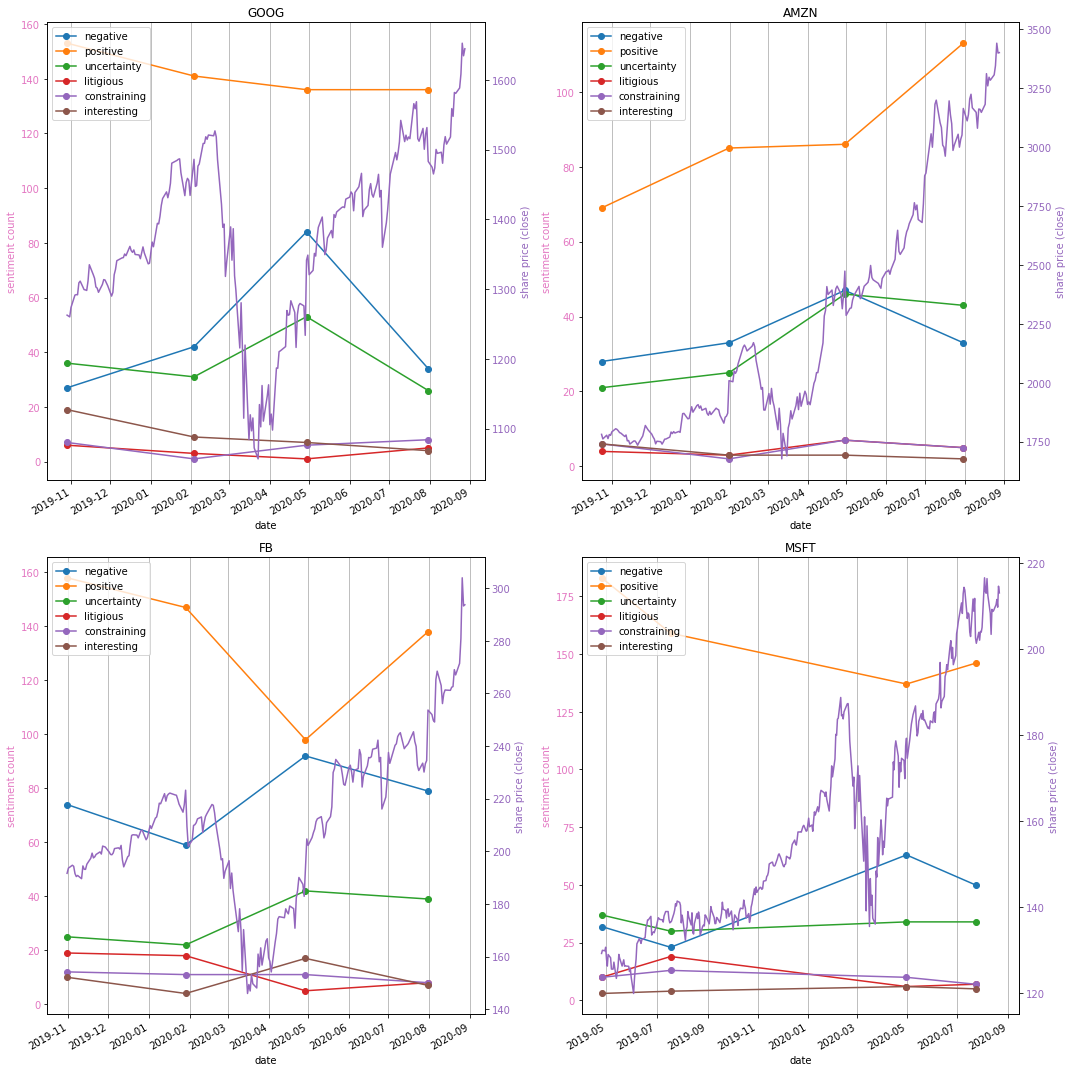

In [30]:
fig = plt.figure(figsize=(15, 15))
fig.autofmt_xdate()
tickers = df['ticker'].unique().tolist()
for index, ticker in enumerate(tickers):
    pos = 220 + index + 1 # to create fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)
    ax1 = fig.add_subplot(pos)

    sub_df = df.loc[df['ticker']==ticker,['call_date']+sentiments]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    valid_date_range = \
    ((close_df.index >= sub_df['call_date'].min()) & 
     (close_df.index <= sub_df['call_date'].max() + timedelta(days=days_after)))
    price_sub_df = close_df.loc[valid_date_range,ticker]

    color = 'tab:pink'
    ax1.set_xlabel('date')
    ax1.set_ylabel('sentiment count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.plot(sub_df['call_date'], sub_df[sentiments], marker='o')
    ax1.set_title(ticker)
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax1.legend(sentiments, loc='upper left')
    ax1.xaxis.grid() # vertical lines

    
    color = 'tab:purple'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('share price (close)', color=color)  # we already handled the x-label with ax1
    ax2.plot(price_sub_df.index, price_sub_df, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**Save the plot** 

In [31]:
fig.savefig('SentimentOverlaidWithPrice.png')